In [125]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
from numpy import matmul
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from numpy import ndarray

import scipy.optimize

plt.rcParams["figure.figsize"] = (20, 10)

In [126]:
"""
Finds gradient of function fun in point x with precision O(h^2).
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
@param args_num: number of function arguments (not parameters)
"""
class ParametrizedFun:
    def __init__(self, fun:Callable[[List[float], List[float]], float], args_num:int):
        self.fun = fun
        self.args_num = args_num

    def at_point(self, x:List[float]):
        return partial(self.fun, x)

    def with_params(self, b:List[float]):
        return partial(self.fun, b=b)

def np_map(fun:Callable[[List[float]], float], a:List[List[float]]) -> ndarray:
    return np.array(list(map(fun, a)))

def generate_dataset(parametrized_fun:ParametrizedFun, b:List[float], size:int=100, r:tuple=(-10, 10), deviation:float=1):
    eval_fun = parametrized_fun.with_params(b)
    features = np.random.rand(size, parametrized_fun.args_num) * (r[1] - r[0]) + r[0]
    error = np.random.normal(0, deviation, size)
    dependent_var = np_map(eval_fun, features) + error
    return [features, dependent_var]

class SumFun:
    def __init__(self, features:List[List[float]], dependent_var:List[float], fun:ParametrizedFun):
        self._fun = fun
        self.terms = np.empty(len(features), dtype=partial)
        self.r = np.empty(len(features), dtype=partial)
        for i in range(len(features)):
            self.r[i] = partial(lambda features, dependent_var, b: (fun.at_point(features))(b) - dependent_var, features[i], dependent_var[i])
            self.terms[i] = partial(lambda features, dependent_var, b: np.square(fun.at_point(features)(b) - dependent_var), features[i], dependent_var[i])
        self.fun = reduce(lambda f1, f2: lambda x: f1(x) + f2(x), self.terms)

    @classmethod
    def from_fun(cls, fun:Callable):
        f = ParametrizedFun(lambda x, b: fun(b), 0)
        features = [[]]
        dependent_var = [0]
        return SumFun(features, dependent_var, f)

    def evaluate_r(self, x:ndarray) -> List[float]:
        res = np.empty(len(self.r), dtype=float)
        for i in range(len(self.r)):
            res[i] = self.r[i](x)
        return res

    def r_grad(self, x:ndarray) -> ndarray:
        j = np.zeros((len(self.r), len(x)))
        for i in range(len(self.r)):
            j[i] = grad(self.r[i], x)
        return j

    def grad(self, x:ndarray) -> ndarray:
        return 2 * np.matmul(self.r_grad(x).transpose(), self.evaluate_r(x))

    def hess_appr(self, x:ndarray) -> ndarray:
        j = self.r_grad(x)
        return 2 * np.matmul(j.transpose(), j)

    def get_model(self, x:ndarray):
        fun = self.get_fun()(x)
        g = self.grad(x)
        h = self.hess_appr(x)
        return partial(lambda fun, g, h, p: fun + matmul(g.transpose(), p) + 1/2 * matmul(matmul(p.transpose(), h), p), fun, g, h)

    def get_fun(self):
        return self.fun

def gauss_newton(fun:SumFun, x:List[float], max_epoch:int, lr:float=1, stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = sum_fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        p = -matmul(inv(fun.hess_appr(x)), fun.grad(x))
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x = x + lr * 1e-4 * p
        else:
            x = x + lr * alpha[0] * p
        points.append(x)
    return np.array(points)

def plot_path_contours(sum_fun:SumFun, points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    fun = sum_fun.get_fun()
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('Descent path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])))

def print_result(points:ndarray, actual_min:ndarray=None, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    if actual_min is None:
        print(f'Precision: unknown')
    else:
        print(f'Precision: {actual_min - min_point}')
    print(f'Min point: {min_point}')
    print(f'Iterations: {len(points)}')
    print(f'Path: {points}')

def bin_search(fun:Callable[[float], float], c:float, eps:float=1e-3, r:tuple=(0, 1)):
    left, right = r
    while right - left > eps:
        mid = (left + right) / 2
        if fun(mid) < c:
            left = mid
        else:
            right = mid
    return (left + right) / 2

def dogleg(fun:SumFun, x:List[float], max_epoch:int, delta:float, min_delta:float=0, max_delta:float=1e2,stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = fun.grad(x)
        h = fun.hess_appr(x)
        # print("h", h)
        b = -matmul(inv(h), g)
        if norm(b) <= delta:
            p = b
        else:
            a = -matmul(g.transpose(), g) / matmul(matmul(g.transpose(), h), g) * g
            if norm(a) > delta:
                p = delta / norm(a) * a
            else:
                ff = lambda t: norm(a + t * (b - a))
                p = a + bin_search(ff, delta) * (b - a)
        m = fun.get_model(x)
        k = (f(x) - f(x + p)) / (m(np.zeros(len(p)) - m(p)))
        x = x + p
        if k < 0.25:
            delta = max(delta / 4, min_delta)
        elif np.abs(norm(p) - delta) < 1e-5:
            delta = min(2 * delta, max_delta)
        points.append(x)
    return np.array(points)

def calc_next_h(h, s, y):
    r = 1 / matmul(y.transpose(), s)
    v = np.identity(len(s)) - r * matmul(y, s.transpose())
    return matmul(matmul(v.transpose(), h), v) + r * matmul(s, s.transpose())

def calc_next_p(s:ndarray, y:ndarray, g:ndarray) -> ndarray:
    q = g
    alpha = np.zeros(len(s))
    ro = np.zeros(len(s))
    for i in range(len(s) - 1, -1, -1):
        ro[i] = 1 / matmul(y[i].transpose(), s[i])
        alpha[i] = ro[i] * matmul(s[i].transpose(), q)
        q = q - alpha[i] * y[i]
    if len(s) > 0:
        h = matmul(s[-1].transpose(), y[-1]) / matmul(y[-1].transpose(), y[-1]) * np.identity(len(g))
    else:
        h = np.identity(len(g))
    r = matmul(h, q)
    for i in range(len(s)):
        beta = ro[i] * matmul(y[i].transpose(), r)
        r = r + s[i] * (alpha[i] - beta)
    return -r

def bfgs(fun:SumFun, x:ndarray, max_epoch:int, h0:ndarray=None, stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    if h0 is None:
        h = inv(fun.hess_appr(x))
    else:
        h = h0
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = -matmul(h, g)
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s = x_next - x
        y = sum_fun.grad(x_next) - g
        h = calc_next_h(h, s, y)

        x = x_next
        points.append(x)
    return np.array(points)

def l_bfgs(fun:SumFun, x:ndarray, max_epoch:int, m:int=4, stop_criteria:Callable[[List[List[float]]], bool]=lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-4).all()) -> ndarray:
    points = [x]
    f = fun.get_fun()
    s = []
    y = []
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = calc_next_p(s, y, g)
        alpha = scipy.optimize.line_search(f, fun.grad, x, p, c1=1e-4, c2=0.9)
        # Иначе может упасть, если stop_criteria плохой
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s.append(x_next - x)
        y.append(sum_fun.grad(x_next) - g)
        if len(s) > m:
            s.pop(0)
            y.pop(0)

        x = x_next
        points.append(x)
    return np.array(points)

In [127]:
from timeit import default_timer as timer

def test(sum_fun, tested_function, x, title="Unknown", max_epoch=200):
    stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
    start_time = timer()
    points = tested_function(sum_fun, x, max_epoch, stop_criteria=stop_criteria)
    time = timer() - start_time
    print(title)
    print(f'Deviation: {b - points[-1]}')
    print(f'Epochs: {len(points)}')
    print(f'Elapsed time: {time * 1000} ms')
    print(f'Time on epoch: {time / len(points) * 1000} ms\n')

n = 2
#Rosenbrock
b = [1, 100]
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))
sum_fun = SumFun.from_fun(rosenbrock)

print("Rosenbrock function")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")

# Function from first lecture
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Function from first lecture")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Euclid distance
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Euclid distance function")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Lineal function (two parameters)
b = [10, -4]
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + b[1] * x[0], 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Lineal function (two params)")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Lineal function (100 parameters)
n = 20
b = np.random.rand(n) * 20 - 10
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + np.sum(b[1:] * x), n - 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print(f'Lineal function ({n} params)')
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

Rosenbrock function
L-BFGS
Deviation: [1.14220413e-02 9.90228799e+01]
Epochs: 29
Elapsed time: 14.49770003091544 ms
Time on epoch: 0.499920690721222 ms

Function from first lecture
L-BFGS
Deviation: [1.20392875e-06 3.49354775e-05]
Epochs: 10
Elapsed time: 273.5232999548316 ms
Time on epoch: 27.35232999548316 ms

BFGS
Deviation: [-0.00076891  0.00442127]
Epochs: 165
Elapsed time: 5129.312900011428 ms
Time on epoch: 31.08674484855411 ms

Gauss-Newton
Deviation: [ 2.43386389e-09 -3.71247144e-08]
Epochs: 7
Elapsed time: 171.27579997759312 ms
Time on epoch: 24.467971425370447 ms

Dogleg
Deviation: [ 3.38877926e-10 -4.66465799e-09]
Epochs: 12
Elapsed time: 298.27909998130053 ms
Time on epoch: 24.85659166510838 ms

Euclid distance function
L-BFGS
Deviation: [-0.0025203   0.01273941]
Epochs: 5
Elapsed time: 871.8890999443829 ms
Time on epoch: 174.37781998887658 ms

BFGS
Deviation: [0.00071388 0.00984958]
Epochs: 25
Elapsed time: 4070.705199963413 ms
Time on epoch: 162.82820799853653 ms

Gauss-

## L-BFGS with rosenbrock

Precision: [0.45621066 0.71461831]
Min point: [0.54378934 0.28538169]
Iterations: 50
Path: [[0.         0.        ]
 [0.18886498 0.        ]
 [0.18389465 0.04185688]
 [0.20104053 0.0297521 ]
 [0.20799802 0.04800501]
 [0.22399266 0.04090484]
 [0.2368437  0.07069696]
 [0.25971307 0.04773295]
 [0.25804623 0.06754748]
 [0.28136544 0.06620398]
 [0.28263052 0.08530203]
 [0.2947809  0.07958748]
 [0.30375941 0.09977003]
 [0.31549064 0.0927976 ]
 [0.32408744 0.11131308]
 [0.33469635 0.10596345]
 [0.34405094 0.12412101]
 [0.36151211 0.11620017]
 [0.35870946 0.13367315]
 [0.37319117 0.12796009]
 [0.37244502 0.14078455]
 [0.38328194 0.13937917]
 [0.38602999 0.15331841]
 [0.39757115 0.14957383]
 [0.39828362 0.15943291]
 [0.41494848 0.16013907]
 [0.41278995 0.17181431]
 [0.42900217 0.17135001]
 [0.42622457 0.18263578]
 [0.43969435 0.18313607]
 [0.43831603 0.19242961]
 [0.45038236 0.19416593]
 [0.44983334 0.20233815]
 [0.46159518 0.20481454]
 [0.461165   0.21258735]
 [0.47247569 0.21528946]
 [0.47179

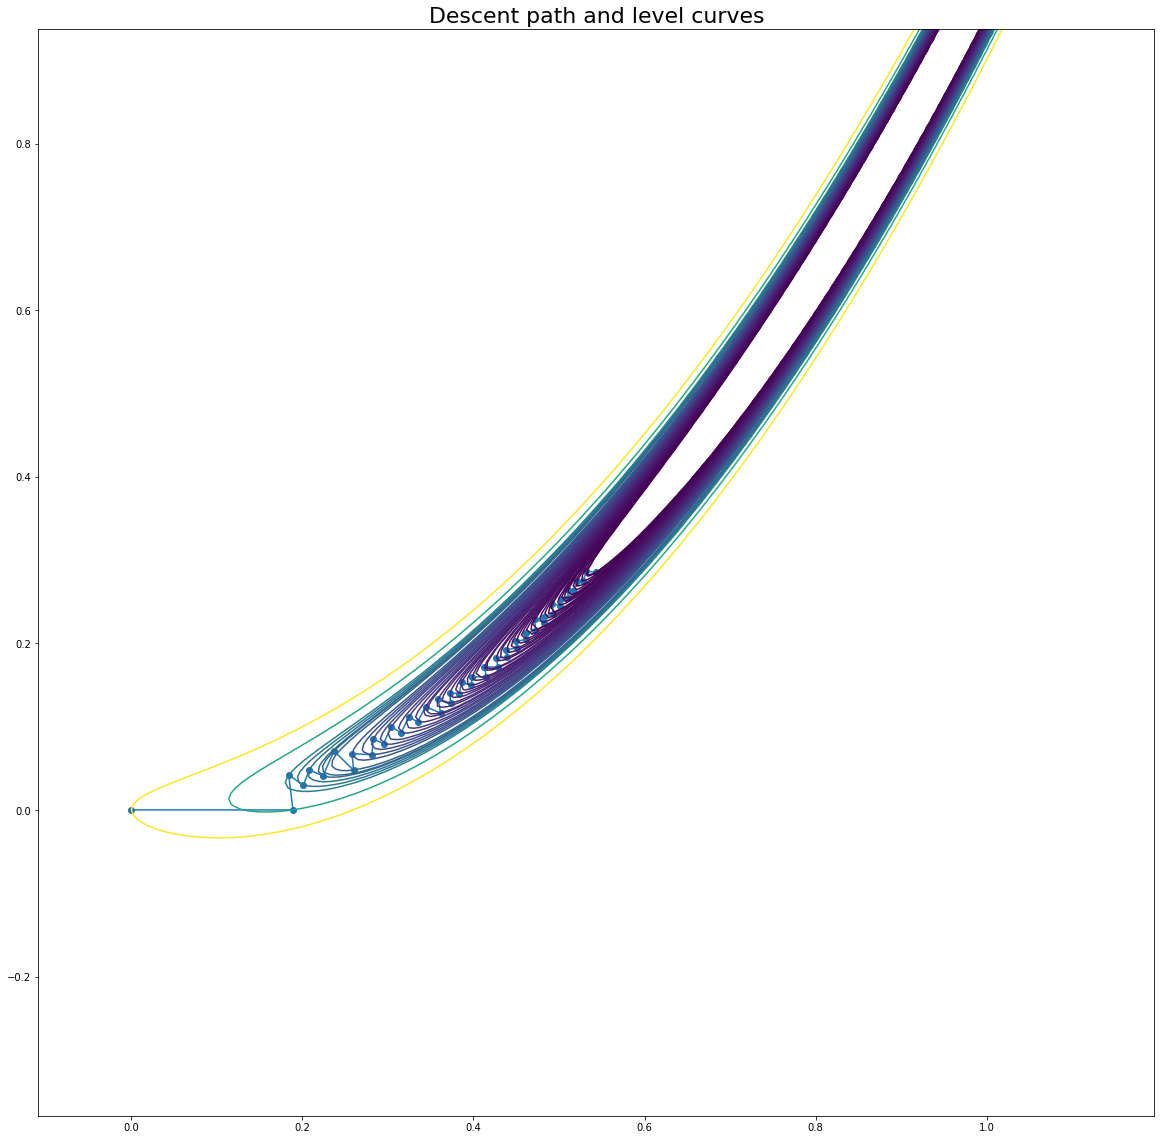

In [128]:
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))

sum_fun = SumFun.from_fun(rosenbrock)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50, h0=np.identity(len(x)))

min_point = np.array([1, 1])
print_result(points, min_point)
plot_path_contours(sum_fun, points)

## L-BFGS

Precision: [-2.59739865e-07  2.21710780e-06]
Min point: [0.50000026 1.99999778]
Iterations: 11
Path: [[ 0.          0.        ]
 [ 0.37919192 -0.0067533 ]
 [ 0.22604637  0.00389872]
 [ 0.23156718  0.0288144 ]
 [ 0.46717051  1.98206173]
 [ 0.4768225   2.05724439]
 [ 0.48168918  2.05076566]
 [ 0.50091479  1.99491802]
 [ 0.4999301   2.0006103 ]
 [ 0.49999164  1.99999234]
 [ 0.50000026  1.99999778]]


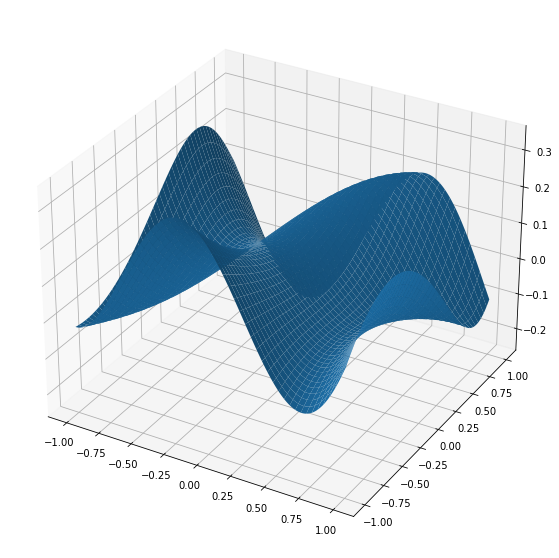

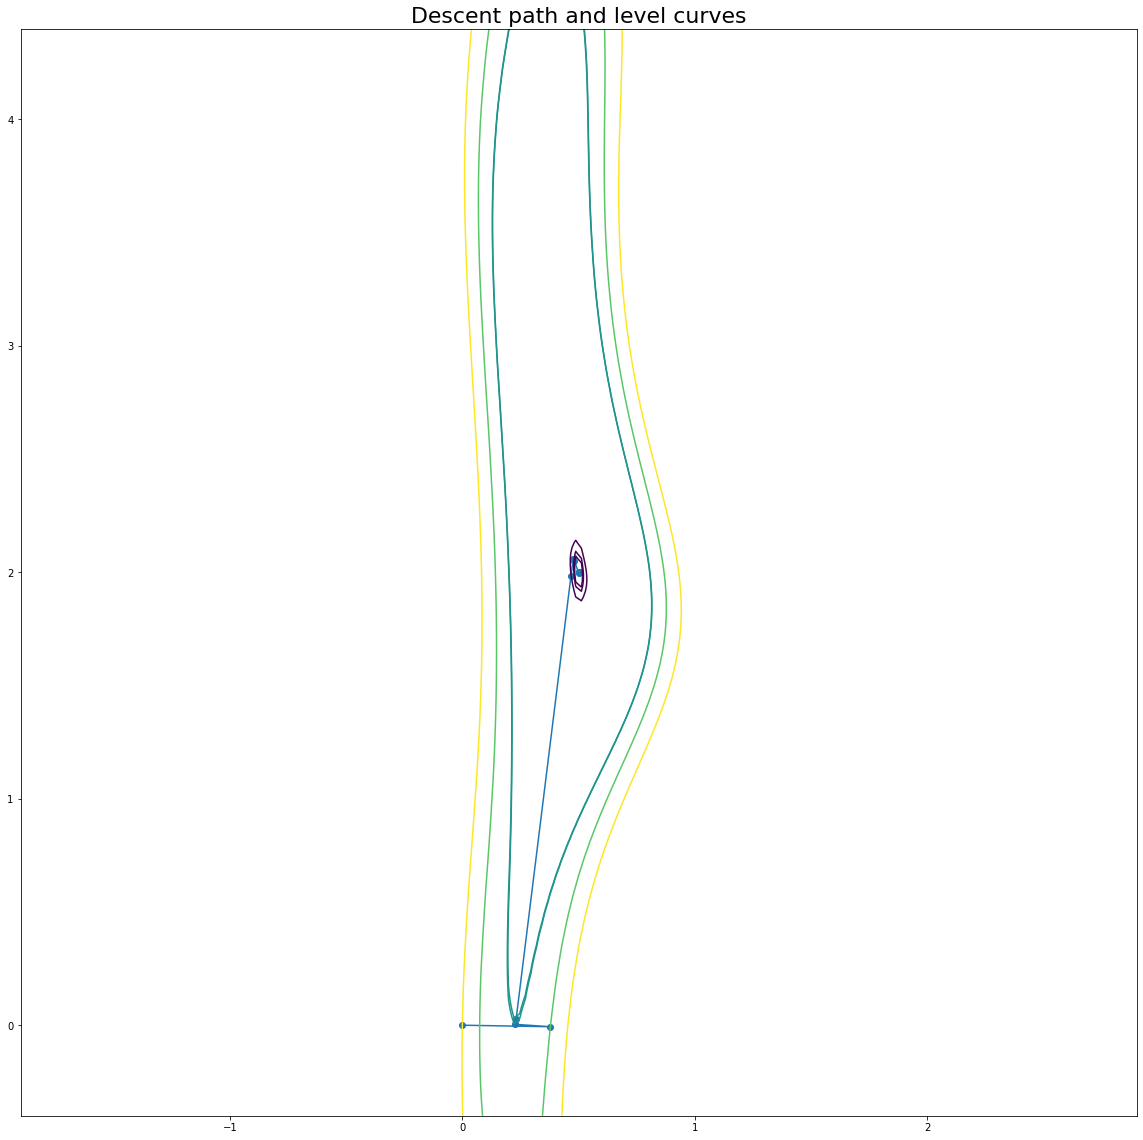

In [129]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = l_bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## BFGS

Precision: [0.02302583 0.00147622]
Min point: [0.47697417 1.99852378]
Iterations: 50
Path: [[0.         0.        ]
 [0.24570159 0.33760396]
 [0.2636051  0.34300062]
 [0.38634544 2.00464761]
 [0.45982499 2.06952167]
 [0.46397043 2.07246323]
 [0.46004845 2.066205  ]
 [0.46417383 2.06936467]
 [0.45960313 2.06047465]
 [0.46452332 2.06469436]
 [0.45367279 1.98961756]
 [0.47304761 2.00895798]
 [0.47547498 2.01091816]
 [0.47388449 2.00826954]
 [0.47579406 2.00975772]
 [0.47436199 2.00755277]
 [0.47603217 2.00882313]
 [0.47468354 2.00683567]
 [0.4762222  2.00799071]
 [0.47493247 2.0061373 ]
 [0.4763835  2.00722021]
 [0.4751423  2.0054644 ]
 [0.47652649 2.00649592]
 [0.47532836 2.0048191 ]
 [0.47665701 2.00581021]
 [0.47549838 2.00420145]
 [0.47677839 2.00515853]
 [0.47565655 2.00361061]
 [0.47689263 2.00453766]
 [0.47580529 2.0030453 ]
 [0.47700095 2.00394506]
 [0.47594613 2.0025041 ]
 [0.47710416 2.0033786 ]
 [0.47608007 2.00198557]
 [0.47720283 2.00283642]
 [0.47620784 2.00148833]
 [0.47729

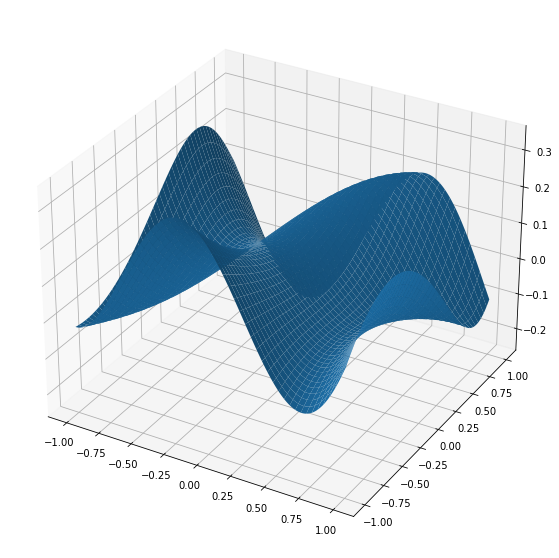

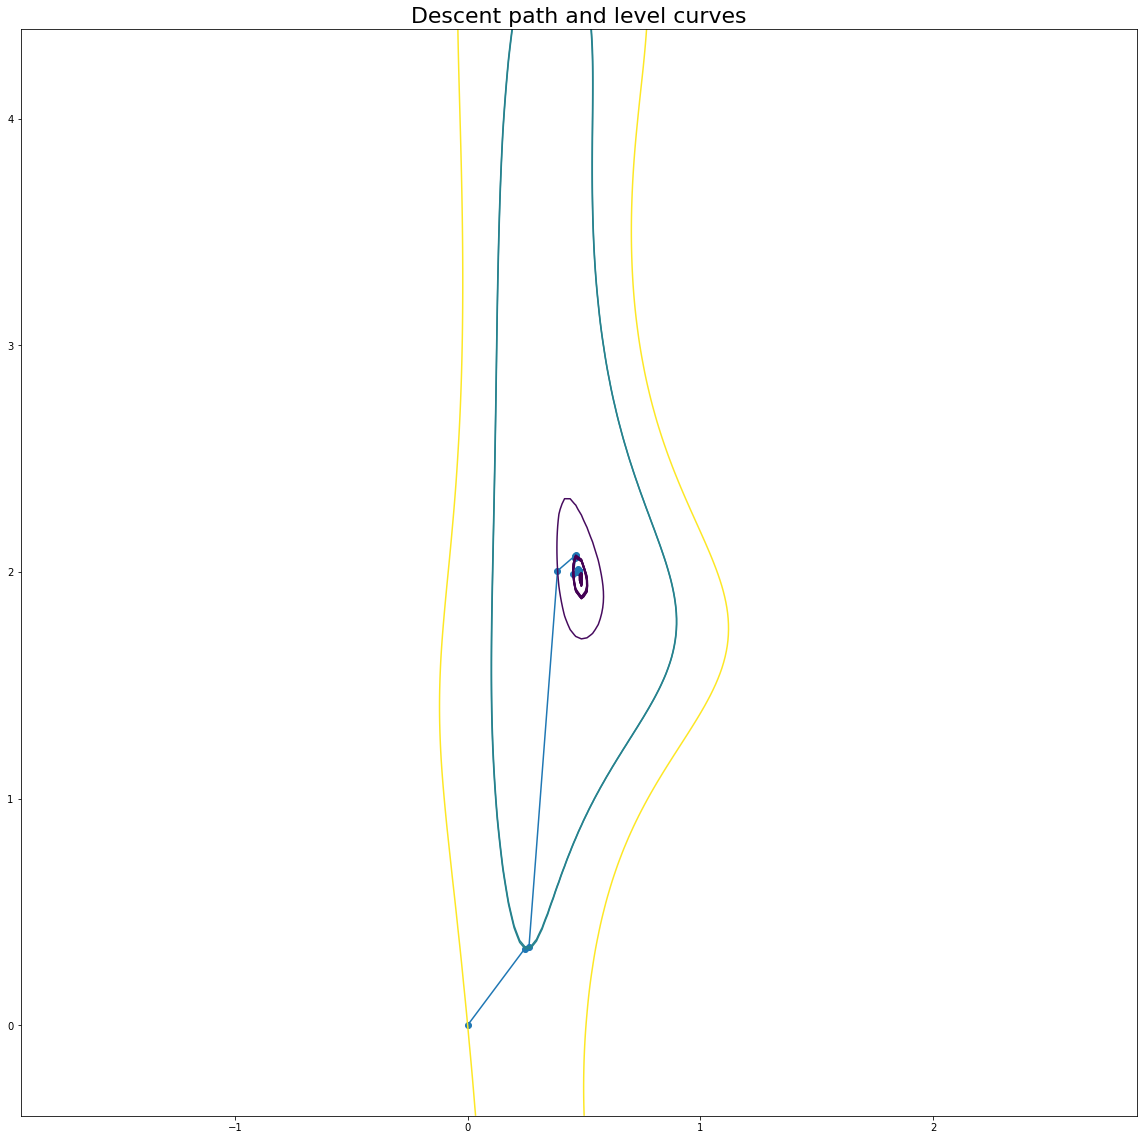

In [130]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Dogleg

Precision: [-0.02757063 -0.05684163]
Min point: [0.52757063 2.05684163]
Iterations: 20
Path: [[ 0.          0.        ]
 [ 0.20765749 -0.06430593]
 [ 0.20476397  0.18573596]
 [ 0.22071267  0.43523473]
 [ 0.24065068  0.68434649]
 [ 0.27098487  0.93226305]
 [ 0.32052604  1.17746439]
 [ 0.40742769  1.41169425]
 [ 0.49331398  1.64647829]
 [ 0.54773189  1.8904838 ]
 [ 0.53223772  2.04542098]
 [ 0.52802913  2.05595114]
 [ 0.52760912  2.05676471]
 [ 0.52757393  2.05683526]
 [ 0.52757091  2.05684108]
 [ 0.52757066  2.05684159]
 [ 0.52757064  2.05684163]
 [ 0.52757063  2.05684163]
 [ 0.52757063  2.05684163]
 [ 0.52757063  2.05684163]]


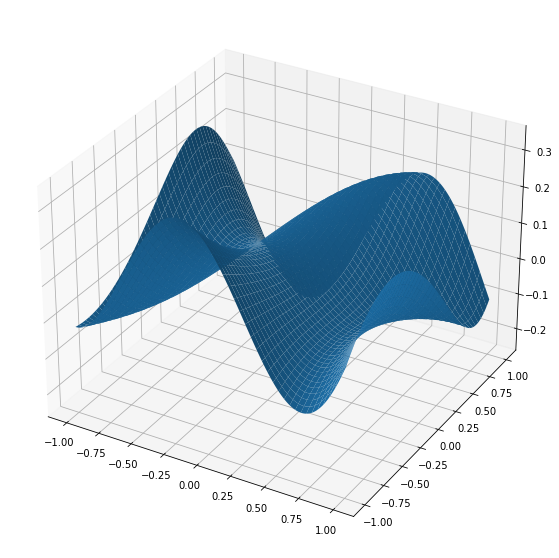

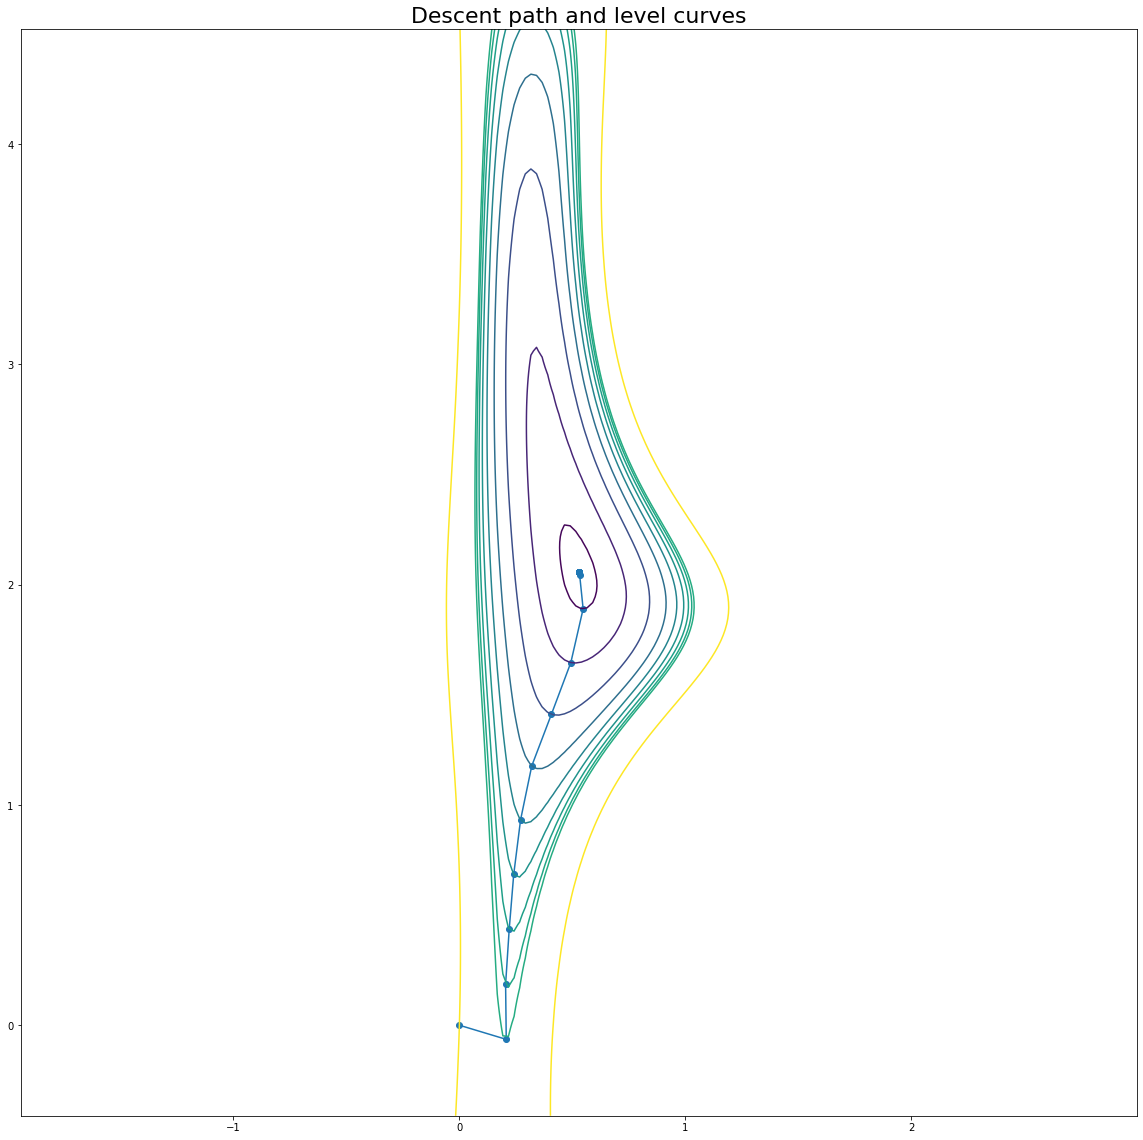

In [131]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = dogleg(sum_fun, x, 20, 1, min_delta=0.25)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Gauss-Newton

C:\Users\super\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Precision: [ 0.00450489 -0.00472878]
Min point: [3.99549511 3.00472878]
Iterations: 20
Path: [[0.         0.        ]
 [3.54378354 2.64826802]
 [4.0027838  3.00891617]
 [3.99545158 3.00469629]
 [3.99549535 3.00472906]
 [3.9954951  3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]
 [3.99549511 3.00472878]]


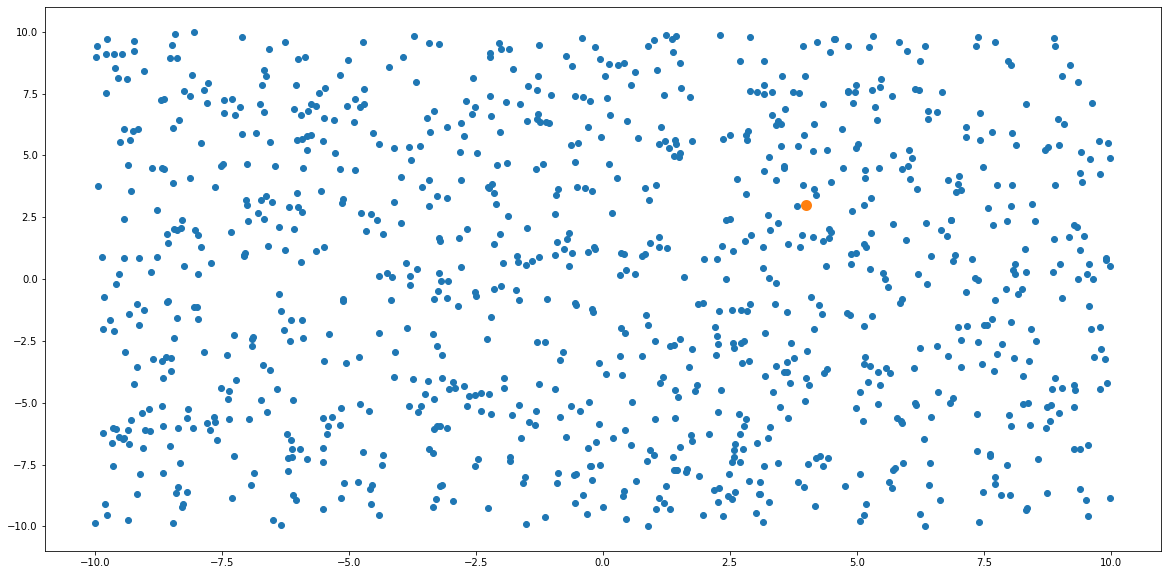

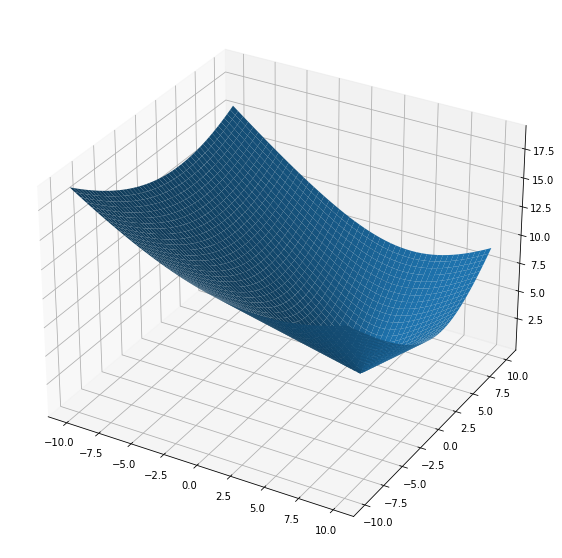

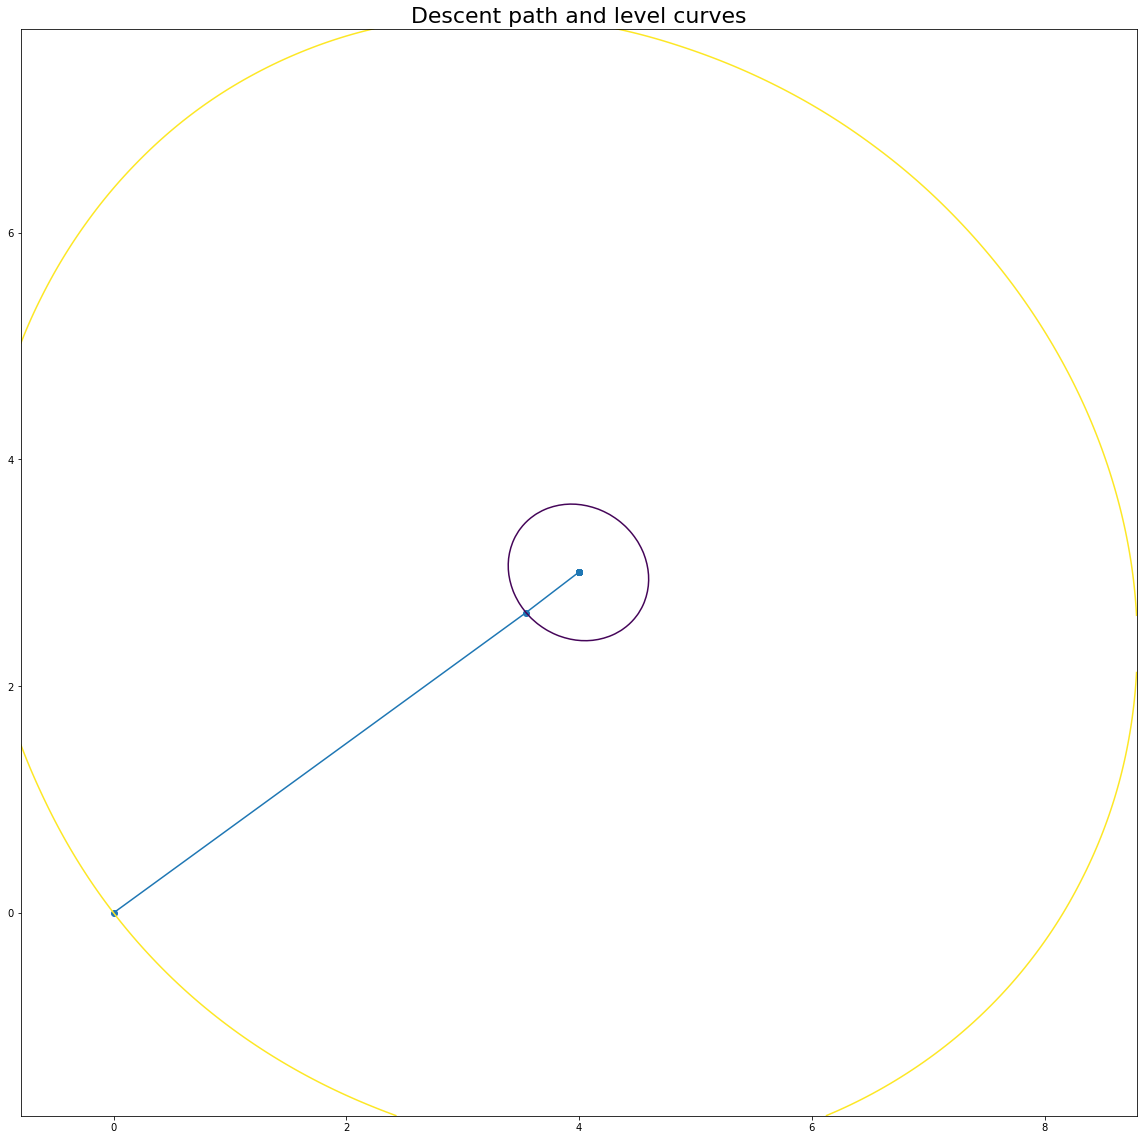

In [132]:
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Практическая задача

Precision: unknown
Min point: [-0.21976557 -0.20814405]
Iterations: 20
Path: [[ 0.          0.        ]
 [-0.03099184 -0.03553994]
 [-0.05798681 -0.06530987]
 [-0.08148295 -0.09022814]
 [-0.10191977 -0.1110688 ]
 [-0.11968427 -0.12848422]
 [-0.13511651 -0.14302402]
 [-0.14851481 -0.15515119]
 [-0.16014053 -0.16525558]
 [-0.17022239 -0.17366537]
 [-0.17896038 -0.18065668]
 [-0.18652919 -0.18646173]
 [-0.19308137 -0.19127567]
 [-0.19875003 -0.19526243]
 [-0.20365125 -0.1985596 ]
 [-0.20788624 -0.20128256]
 [-0.2115432  -0.20352799]
 [-0.21469893 -0.2053768 ]
 [-0.21742033 -0.20689665]
 [-0.21976557 -0.20814405]]


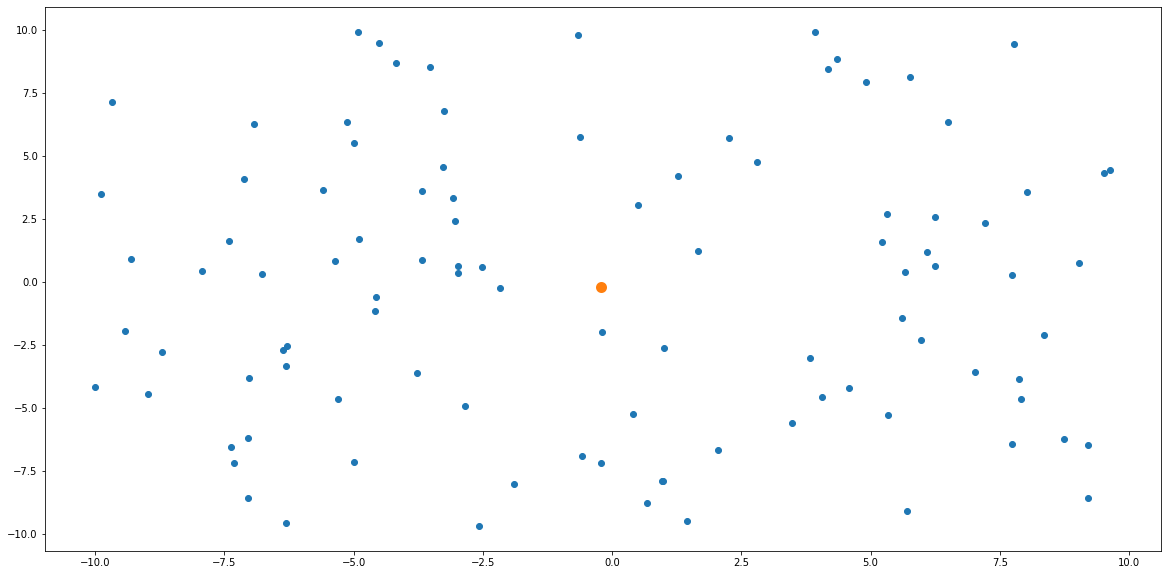

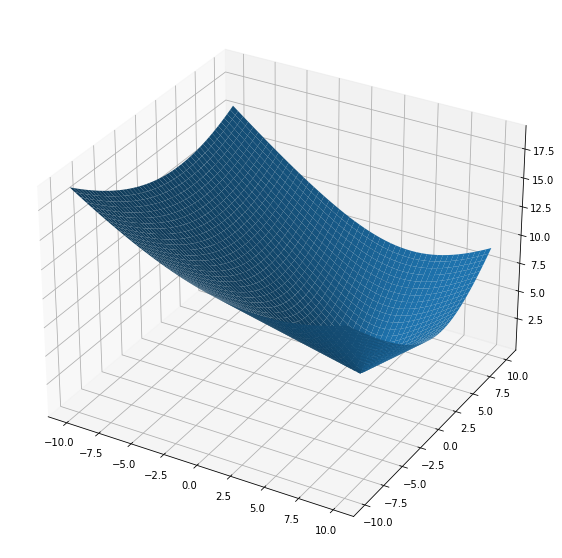

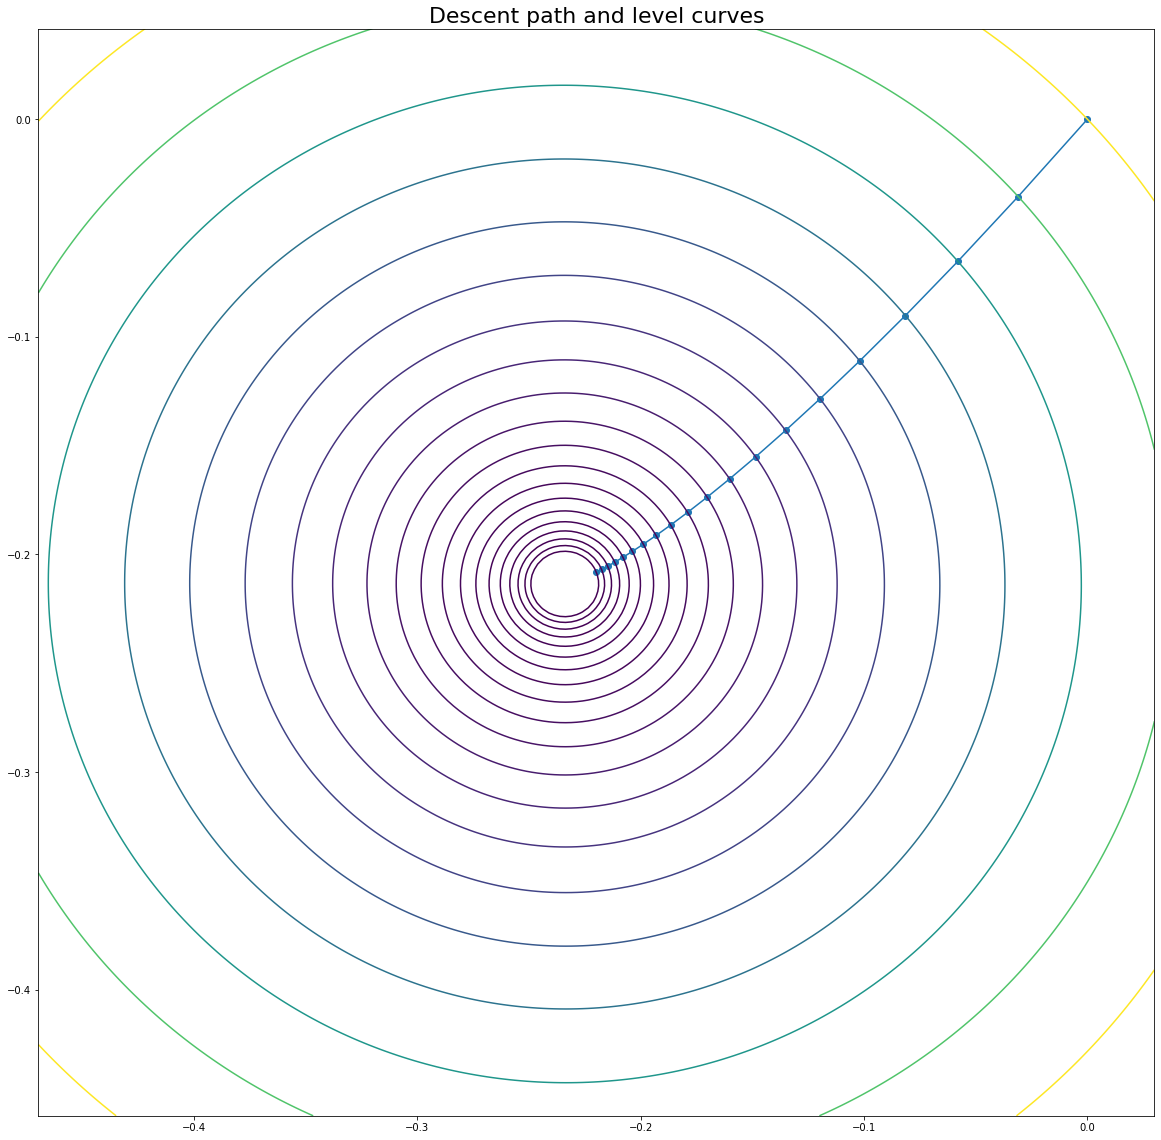

In [133]:
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(ParametrizedFun(lambda x, b: 0, 2), [0, 0], size=100, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
lr = 0.15
points = gauss_newton(sum_fun, x, 20, lr)

print_result(points)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Очень нелинейная функция

Precision: [0. 0.]
Min point: [0.5 2. ]
Iterations: 20
Path: [[0.         0.        ]
 [0.29666624 0.08324902]
 [0.30741623 1.02083645]
 [0.43218553 1.8589647 ]
 [0.49836561 2.02476923]
 [0.49998235 1.99984168]
 [0.5        2.00000001]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]]


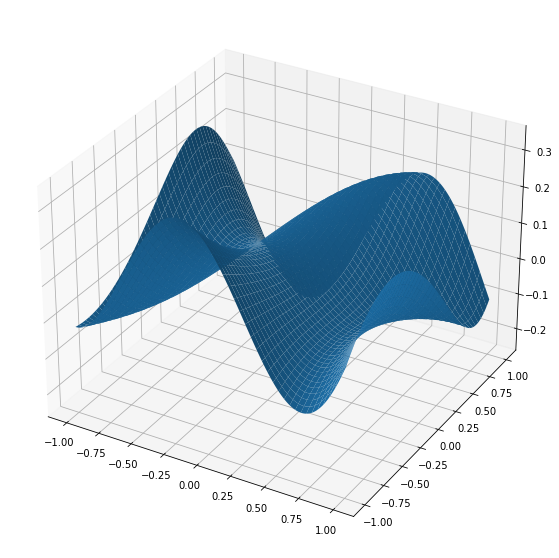

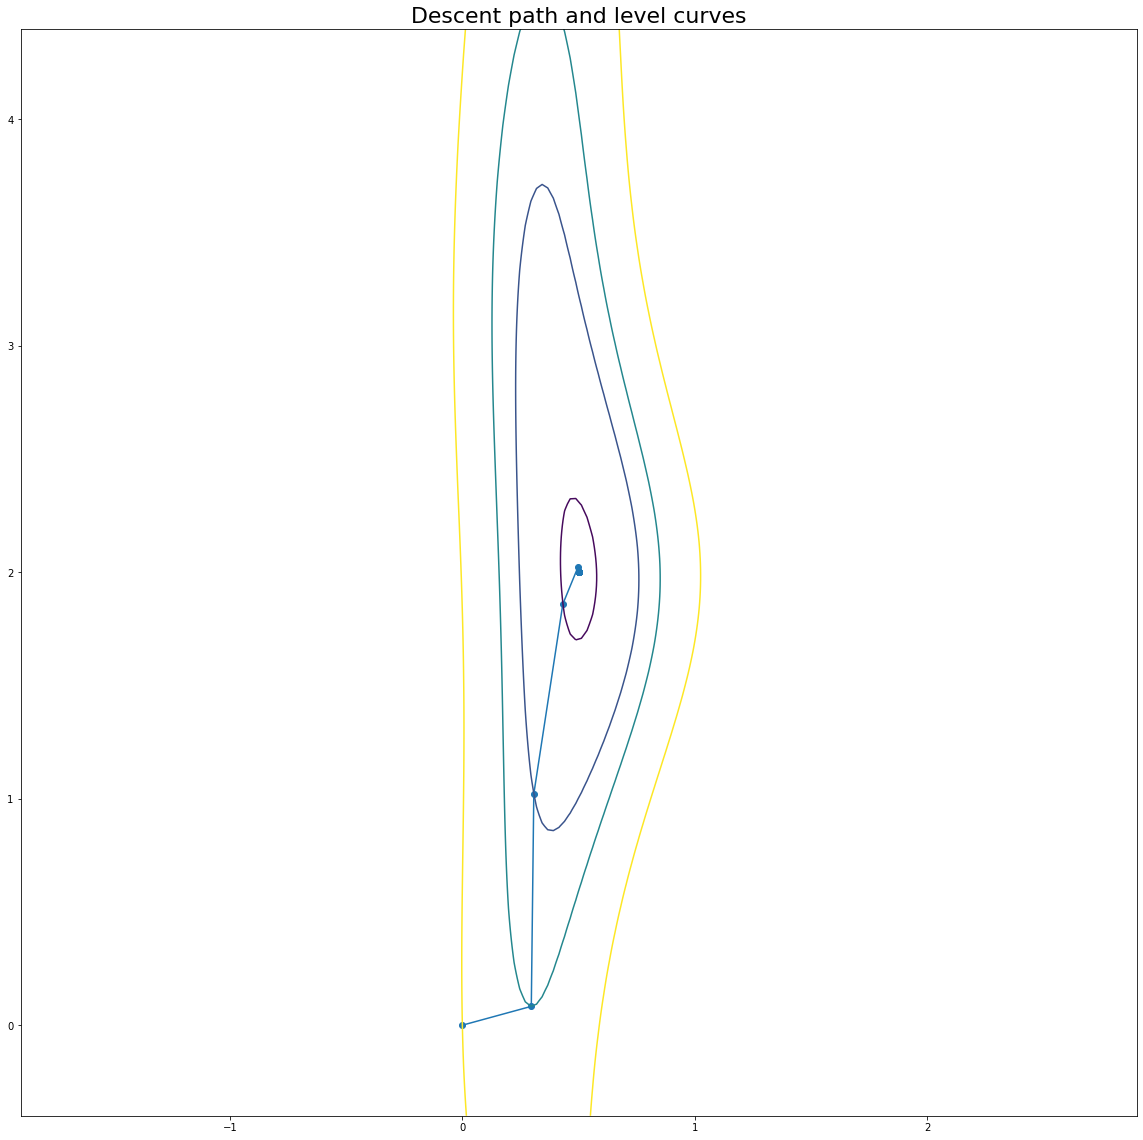

In [134]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
plot_path_contours(sum_fun, points)